In [1]:
import pandas as pd
import numpy as np
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("talk")
sns.set_style("white")

In [ ]:
# from analysis.compute_costs import compute_costs
#
# compute_costs

Note: mostly copied from a notebook from senegal maka pkpd

In [2]:
df = pd.read_csv("malaria_drug_params.csv")
df

,Name,PKPD_Model,Drug_Cmax,Drug_Decay_T1,Drug_Decay_T2,Drug_Vd,Drug_PKPD_C50,Drug_Fulltreatment_Doses,Drug_Dose_Interval,Drug_Gametocyte02_Killrate,Drug_Gametocyte34_Killrate,Drug_GametocyteM_Killrate,Drug_Hepatocyte_Killrate,Max_Drug_IRBC_Kill,Drug_Adherence_Rate,Bodyweight_Exponent,Upper_Age_In_Years,Fraction_Of_Adult_Dose
0,Artemether,CONCENTRATION_VERSUS_TIME,114.0,0.120,0.120,1.00,0.600,6,0.5,2.5,1.5,0.7,0.0,8.90000,1,1.00,"[3,6,10]","[0.25,0.5,0.75]"
1,Lumefantrine,CONCENTRATION_VERSUS_TIME,1017.0,1.300,2.000,1.20,280.000,6,0.5,2.4,0.0,0.0,0.0,4.80000,1,0.35,"[3,6,10]","[0.25,0.5,0.75]"
2,DHA,CONCENTRATION_VERSUS_TIME,200.0,0.120,0.120,1.00,0.600,3,1.0,2.5,1.5,0.7,0.0,9.20000,1,1.00,"[.83,2.83,5.25,7.33,9.42]","[0.375,0.5,0.625,0.75,0.875]"
3,Piperaquine,CONCENTRATION_VERSUS_TIME,30.0,0.170,41.000,49.00,5.000,3,1.0,2.3,0.0,0.0,0.0,4.60000,1,0.00,"[.83,2.83,5.25,7.33,9.42]","[0.375,0.5,0.625,0.75,0.875]"
4,Primaquine,CONCENTRATION_VERSUS_TIME,75.0,0.360,0.360,1.00,15.000,1,1.0,2.0,5.0,50.0,0.1,0.00000,1,1.00,"[5,9,14]","[.17,.33,.67]"
5,Chloroquine,CONCENTRATION_VERSUS_TIME,150.0,8.900,244.000,3.90,150.000,3,1.0,0.0,0.0,0.0,0.0,4.80000,1,1.00,"[5,9,14]","[.17,.33,.67]"
6,Artesunate,CONCENTRATION_VERSUS_TIME,200.0,0.120,0.120,1.00,0.030,3,1.0,2.5,1.5,0.7,0.0,4.20000,1,1.00,"[2,5]","[0.167,0.33]"
7,Sulfadoxine,CONCENTRATION_VERSUS_TIME,105.8,8.550,8.550,1.00,0.200,1,1.0,0.0,0.0,0.0,0.0,0.50600,1,1.00,"[2,5]","[0.167,0.33]"
8,Pyrimethamine,CONCENTRATION_VERSUS_TIME,354.1,5.411,5.411,1.00,2.000,1,1.0,0.0,0.0,0.0,0.0,0.60000,1,1.00,"[2,5]","[0.167,0.33]"
9,Amodiaquine,CONCENTRATION_VERSUS_TIME,1185.0,0.120,6.250,2.51,35.500,3,1.0,0.0,0.0,0.0,0.0,0.67089,1,1.00,"[1,5]","[0.22,0.44]"


# PK

In [3]:
import ast

In [5]:
df_15yo = df.copy()[np.in1d(df["Name"],[
    "DHA",
    "Piperaquine",
    "Artesunate",
    "Amodiaquine",
    "Sulfadoxine",
    "Pyrimethamine"
])].reset_index(drop=True)
df_15yo["15yo_dose_frac"] = df_15yo["Fraction_Of_Adult_Dose"].apply(lambda x: ast.literal_eval(x)[-1])
df_15yo["Drug_Cmax_15yo"] = df_15yo["Drug_Cmax"]*df_15yo["15yo_dose_frac"]

In [6]:
def get_drug_params(drug):
    df_drug = df_15yo[df_15yo["Name"]==drug].reset_index(drop=True)
    return df_drug.iloc[0].to_dict()

In [7]:
from functools import partial

In [14]:
def drug_concentration(t, drug):
    drug_params = get_drug_params(drug)
    cmax = drug_params["Drug_Cmax_15yo"]
    A = drug_params["Drug_Decay_T1"]
    B = drug_params["Drug_Decay_T2"]
    V = drug_params["Drug_Vd"]
    
    # c = cmax * (np.exp(-A*t) + V*np.exp(-B*t))
    c = cmax * (np.exp(-t/A) + np.exp(-t/B)/V)
    return c

In [15]:
def plot_drug_concentration_vs_days(drug, tmax_days=100):
    t = np.linspace(0,tmax_days,1000)
    f = np.vectorize(partial(drug_concentration, drug=drug))
    c = f(t)
    
    drug_params = get_drug_params(drug)
    c50 = drug_params["Drug_PKPD_C50"]
    
    plt.plot(t,c, label="Single-dose")
    plt.axhline(c50, ls='dashed', label="C50", c="C1")
    plt.title(drug)
    plt.xlabel("Time (days)")
    plt.ylabel("Concentration")
    plt.yscale("log")
    plt.legend()
    plt.ylim([0.1,5000])

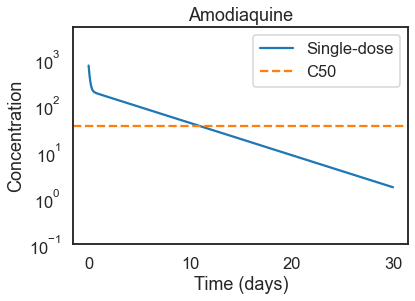

In [9]:
plot_drug_concentration_vs_days("Amodiaquine", tmax_days=30)

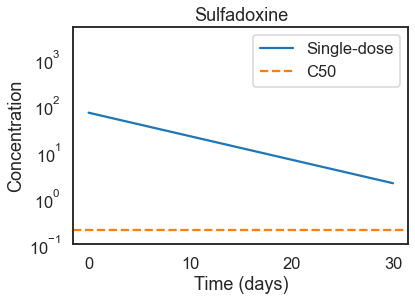

In [13]:
plot_drug_concentration_vs_days("Sulfadoxine", tmax_days=30)

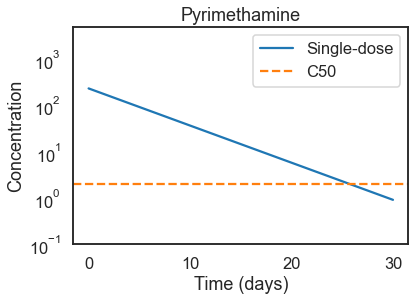

In [14]:
plot_drug_concentration_vs_days("Pyrimethamine", tmax_days=30)

# PD

In [16]:
def kill_rate(t, drug, stage="asexual"):
    drug_params = get_drug_params(drug)
    c50 = drug_params["Drug_PKPD_C50"]
    
    if stage == "asexual":
        kmax = drug_params["Max_Drug_IRBC_Kill"]
    elif stage == "sexual":
        kmax = drug_params["Drug_Gametocyte02_Killrate"] + \
        drug_params["Drug_Gametocyte34_Killrate"] + \
        drug_params["Drug_GametocyteM_Killrate"]
    else:
        raise NotImplementedError
        
    c_t = drug_concentration(t, drug)
    
    return kmax * (c_t/(c_t+c50))

In [17]:
def plot_kill_rate_vs_days(drug, stage="asexual", tmax_days=100, normalize=False, logscale=False):
    t = np.linspace(0,tmax_days,1000)
    f = np.vectorize(partial(kill_rate, drug=drug, stage=stage))
    k = f(t)
    
    plt.figure()
    if normalize:
        if stage == "asexual":
            plt.plot(t,k/9.2) #normalized to DHA
            plt.ylabel("{} kill rate, compared to DHA max".format(stage))
        elif stage == "sexual":
            plt.plot(t,k/57) #normalized to Primaquine
            plt.ylabel("{} kill rate, compared to Piperaquine max".format(stage))
        plt.ylim([0,1])
    else:
        plt.plot(t,k)
        plt.ylabel("{} kill rate".format(stage))
        # if stage == "asexual":
        #     plt.ylim([0,9.2])
        # elif stage == "sexual":
        #     plt.ylim([0,60])
        
    plt.title(drug)
    plt.xlabel("Time (days)")
    if logscale:
        plt.yscale("log")
        plt.ylim([1e-3,1])

    return {"t": t, "k": k}


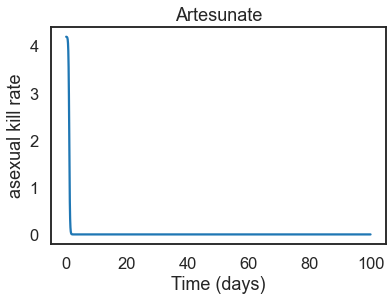

In [24]:
d = plot_kill_rate_vs_days("Artesunate", tmax_days=100)
df_kill_rates_as = pd.DataFrame({"drug": "Artesunate", "time": d["t"], "kill_rate": d["k"]})

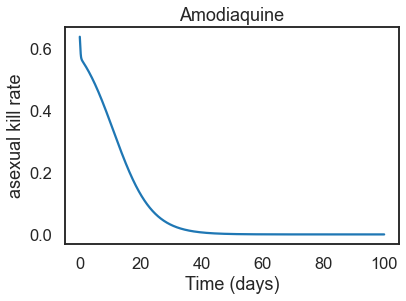

In [18]:
d = plot_kill_rate_vs_days("Amodiaquine", tmax_days=100)
df_kill_rates_aq = pd.DataFrame({"drug": "Amodiaquine", "time": d["t"], "kill_rate": d["k"]})

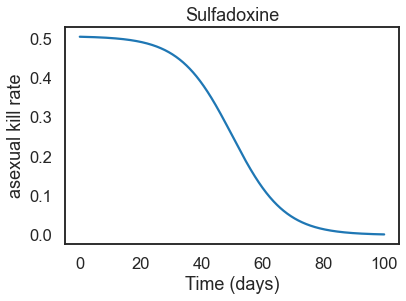

In [19]:
d = plot_kill_rate_vs_days("Sulfadoxine", tmax_days=100)
df_kill_rates_s = pd.DataFrame({"drug": "Sulfadoxine", "time": d["t"], "kill_rate": d["k"]})

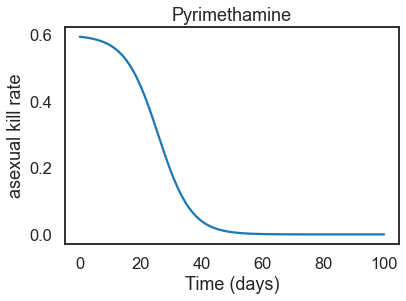

In [20]:
d = plot_kill_rate_vs_days("Pyrimethamine", tmax_days=100)
df_kill_rates_p = pd.DataFrame({"drug": "Pyrimethamine", "time": d["t"], "kill_rate": d["k"]})

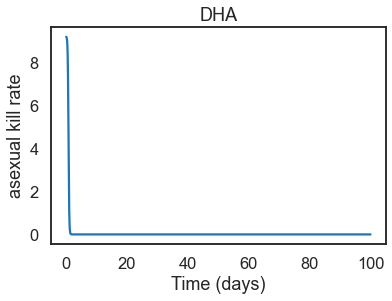

In [25]:
d = plot_kill_rate_vs_days("DHA", tmax_days=100)
df_kill_rates_dha = pd.DataFrame({"drug": "DHA", "time": d["t"], "kill_rate": d["k"]})

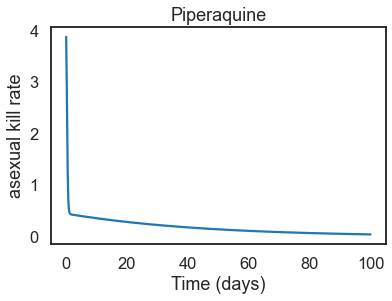

In [26]:
d = plot_kill_rate_vs_days("Piperaquine", tmax_days=100)
df_kill_rates_pip = pd.DataFrame({"drug": "Piperaquine", "time": d["t"], "kill_rate": d["k"]})

In [27]:
df_all = pd.concat([df_kill_rates_as, df_kill_rates_aq, df_kill_rates_s, df_kill_rates_p, df_kill_rates_dha, df_kill_rates_pip], ignore_index=True)

In [31]:
def real_dose_concentration(t, drug_name):
    drug_params = get_drug_params(drug_name)
    cmax = drug_params["Drug_Cmax_15yo"]
    A = drug_params["Drug_Decay_T1"]
    B = drug_params["Drug_Decay_T2"]
    V = drug_params["Drug_Vd"]
    
    
    c = cmax * (np.exp(-t/A) + np.exp(-t/B)/V)
    
    if drug_name in ["Artesunate", "Amodiaquine", "DHA", "Piperaquine"]: #multi-dose
        if t > 1:
            c += cmax * (np.exp(-(t-1)/A) + np.exp(-(t-1)/B)/V)
        if t > 2:
            c += cmax * (np.exp(-(t-2)/A) + np.exp(-(t-2)/B)/V)
    
    return c

In [32]:
def plot_drug_concentration_vs_days(drug, tmax_days=100):
    t = np.linspace(0,tmax_days,1000)
    
    f = np.vectorize(partial(real_dose_concentration, drug_name=drug))
    c = f(t)
    
    drug_params = get_drug_params(drug)
    c50 = drug_params["Drug_PKPD_C50"]
    
    plt.plot(t,c, label="Single-dose")
    plt.axhline(c50, ls='dashed', label="C50", c="C1")
    plt.title(drug)
    plt.xlabel("Time (days)")
    plt.ylabel("Concentration")
    plt.yscale("log")
    plt.legend()
    plt.ylim([0.1,5000])

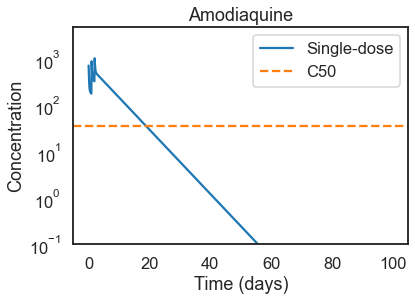

In [33]:
plot_drug_concentration_vs_days("Amodiaquine")

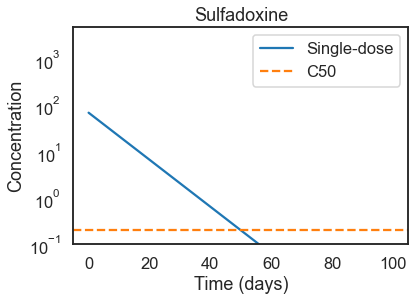

In [34]:
plot_drug_concentration_vs_days("Sulfadoxine")

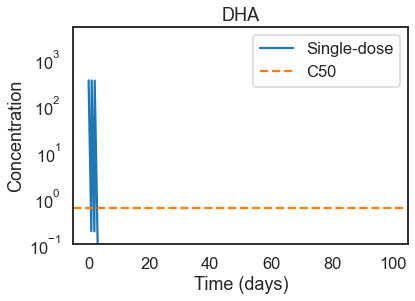

In [35]:
plot_drug_concentration_vs_days("DHA")

In [36]:
def kill_rate(t, drug, stage="asexual"):
    drug_params = get_drug_params(drug)
    c50 = drug_params["Drug_PKPD_C50"]
    
    if stage == "asexual":
        kmax = drug_params["Max_Drug_IRBC_Kill"]
    elif stage == "sexual":
        kmax = drug_params["Drug_Gametocyte02_Killrate"] + \
        drug_params["Drug_Gametocyte34_Killrate"] + \
        drug_params["Drug_GametocyteM_Killrate"]
    else:
        raise NotImplementedError
    
    c_t = real_dose_concentration(t, drug)
        
    return kmax * (c_t/(c_t+c50))

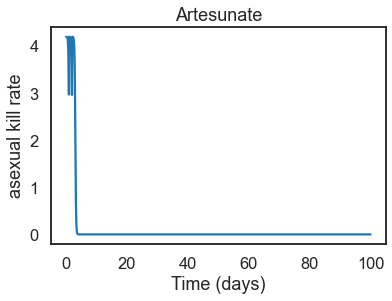

In [38]:
d = plot_kill_rate_vs_days("Artesunate", tmax_days=100)
df_kill_rates_as_actual = pd.DataFrame({"drug": "Artesunate", "time": d["t"], "kill_rate": d["k"], "resistance": False})

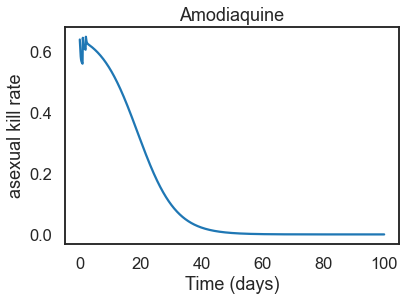

In [37]:
d = plot_kill_rate_vs_days("Amodiaquine", tmax_days=100)
df_kill_rates_aq_actual = pd.DataFrame({"drug": "Amodiaquine", "time": d["t"], "kill_rate": d["k"], "resistance": False})

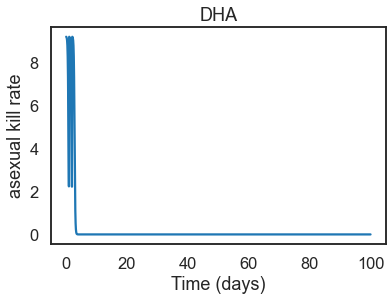

In [42]:
d = plot_kill_rate_vs_days("DHA", tmax_days=100)
df_kill_rates_dha_actual = pd.DataFrame({"drug": "DHA", "time": d["t"], "kill_rate": d["k"], "resistance": False})

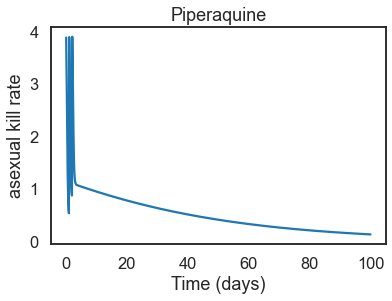

In [41]:
d = plot_kill_rate_vs_days("Piperaquine", tmax_days=100)
df_kill_rates_pip_actual = pd.DataFrame({"drug": "Piperaquine", "time": d["t"], "kill_rate": d["k"], "resistance": False})

In [43]:
df_all_actual = pd.concat([df_kill_rates_aq_actual, 
                           df_kill_rates_as_actual,
                           df_kill_rates_dha_actual, 
                           df_kill_rates_pip_actual, 
                           df_kill_rates_s,
                           df_kill_rates_p], ignore_index=True)

Text(0.5, 1.0, 'SPAQ')

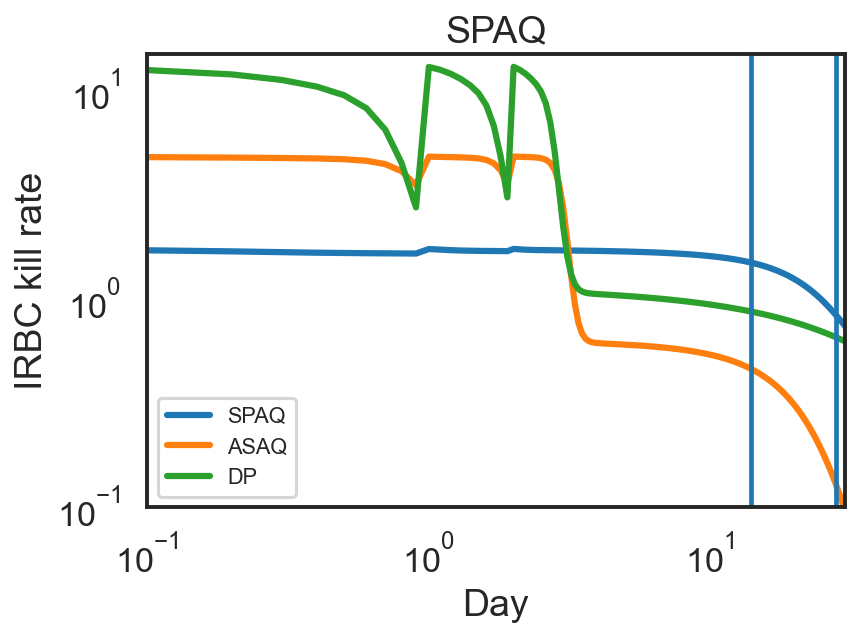

In [60]:
plt.figure(dpi=150)
# plt.plot(df_kill_rates_p["time"], df_kill_rates_s["kill_rate"]+df_kill_rates_p["kill_rate"], label="SP", linestyle='dashed')
# plt.plot(df_kill_rates_p["time"], df_kill_rates_aq_actual["kill_rate"], label="AQ", linestyle='dashed')
# plt.plot(df_kill_rates_p["time"], df_kill_rates_as_actual["kill_rate"], label="AS", linestyle='dashed')
# plt.plot(df_kill_rates_p["time"], df_kill_rates_dha_actual["kill_rate"], label="DHA", linestyle='dashed')
# plt.plot(df_kill_rates_p["time"], df_kill_rates_pip_actual["kill_rate"], label="Pip", linestyle='dashed')
plt.plot(df_kill_rates_p["time"], df_kill_rates_s["kill_rate"]+df_kill_rates_p["kill_rate"]+df_kill_rates_aq_actual["kill_rate"], label="SPAQ",linewidth=3)
plt.plot(df_kill_rates_p["time"], df_kill_rates_as_actual["kill_rate"]+df_kill_rates_aq_actual["kill_rate"], label="ASAQ",linewidth=3)
plt.plot(df_kill_rates_p["time"], df_kill_rates_dha_actual["kill_rate"]+df_kill_rates_pip_actual["kill_rate"], label="DP",linewidth=3)

plt.axvline(28)
plt.axvline(14)
plt.xlim([0.1,30])
plt.ylim([0.1,15])
plt.xscale("log")
plt.yscale("log")
plt.legend(fontsize="xx-small")
plt.ylabel("IRBC kill rate")
plt.xlabel("Day")
plt.title("SPAQ")


Text(0.5, 1.0, 'SPAQ')

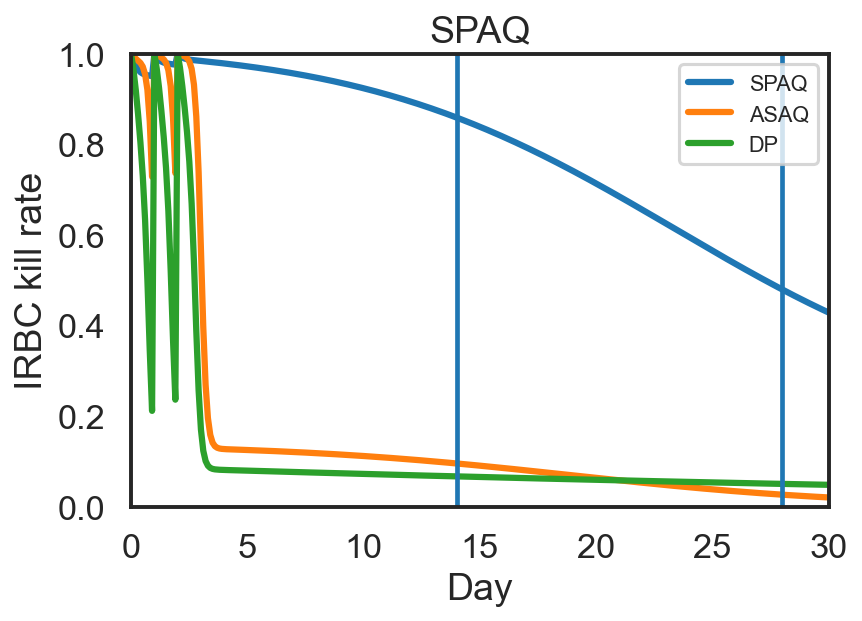

In [65]:
plt.figure(dpi=150)
spaq_kill = df_kill_rates_s["kill_rate"]+df_kill_rates_p["kill_rate"]+df_kill_rates_aq_actual["kill_rate"]
asaq_kill = df_kill_rates_as_actual["kill_rate"]+df_kill_rates_aq_actual["kill_rate"]
dp_kill = df_kill_rates_dha_actual["kill_rate"]+df_kill_rates_pip_actual["kill_rate"]

plt.plot(df_kill_rates_p["time"], spaq_kill/np.max(spaq_kill), label="SPAQ",linewidth=3)
plt.plot(df_kill_rates_p["time"], asaq_kill/np.max(asaq_kill), label="ASAQ",linewidth=3)
plt.plot(df_kill_rates_p["time"], dp_kill/np.max(dp_kill), label="DP",linewidth=3)

plt.axvline(28)
plt.axvline(14)
plt.xlim([0,30])
plt.ylim([0,1])
# plt.xscale("log")
# plt.yscale("log")
plt.legend(fontsize="xx-small")
plt.ylabel("IRBC kill rate")
plt.xlabel("Day")
plt.title("SPAQ")
